In [57]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import tensorflow as tf
import numpy as np
import pandas as pd

import os

matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize

import tensorflow_datasets as tfds

# Load the data
Loading and preparing the data, we only really need the passenger's class and if they survived.  Class is from 0 to 2 for first through third class.

In [58]:
builder = tfds.builder('titanic')

builder.download_and_prepare()

ds = builder.as_dataset(split='train', shuffle_files=True)
print(ds)

<_OptionsDataset shapes: {features: {age: (), boat: (), body: (), cabin: (), embarked: (), fare: (), home.dest: (), name: (), parch: (), pclass: (), sex: (), sibsp: (), ticket: ()}, survived: ()}, types: {features: {age: tf.float32, boat: tf.string, body: tf.int32, cabin: tf.string, embarked: tf.int64, fare: tf.float32, home.dest: tf.string, name: tf.string, parch: tf.int32, pclass: tf.int64, sex: tf.int64, sibsp: tf.int32, ticket: tf.string}, survived: tf.int64}>


In [59]:
ds = tfds.load('titanic', split='train')
#ds = ds.take(1)  # Only take a single example

ds = tfds.as_dataframe(ds)

In [60]:
ds.head()

,features/age,features/boat,features/body,features/cabin,features/embarked,features/fare,features/home.dest,features/name,features/parch,features/pclass,features/sex,features/sibsp,features/ticket,survived
0,30.0,b'Unknown',-1,b'Unknown',2,13.0000,"b'Sarnia, ON'","b'McCrie, Mr. James Matthew'",0,1,0,0,b'233478',0
1,37.0,b'Unknown',98,b'Unknown',2,7.9250,"b'Ruotsinphytaa, Finland New York, NY'","b'Gustafsson, Mr. Anders Vilhelm'",0,2,0,2,b'3101276',0
2,28.0,b'9',-1,b'Unknown',2,13.0000,b'Spain',"b'Reynaldo, Ms. Encarnacion'",0,1,1,0,b'230434',1
3,18.0,b'Unknown',-1,b'Unknown',2,73.5000,"b'Lyndhurst, England'","b'Davies, Mr. Charles Henry'",0,1,0,0,b'S.O.C. 14879',0
4,-1.0,b'Unknown',-1,b'Unknown',0,7.8958,b'Unknown',"b'Gheorgheff, Mr. Stanio'",0,2,0,0,b'349254',0


In [61]:
second = ds[ds["features/pclass"]==1]['survived'].values
third = ds[ds["features/pclass"]==2]['survived'].values
first = ds[ds["features/pclass"]==0]['survived'].values
print(first.mean(), second.mean(),third.mean())

0.6191950464396285 0.4296028880866426 0.2552891396332863


In [62]:
titanic_data =  ds[["features/pclass","survived"]].values

titanic_data = tf.convert_to_tensor(titanic_data, dtype=tf.float32)
pass_class = titanic_data[:, 0]
pass_survival = titanic_data[:, 1]
pass_survival = tf.convert_to_tensor(pass_survival, dtype=tf.float32)


# Joint Log Probability
This function evaluates the log of the joint probability that the model generated the observed data.  

The Markov chain Monte Carlo (MCMC) algorithm guesses at unknown input values and calculates how likely its set of arguments is.

In [63]:
def titanic_joint_log_prob(survival, pass_class, alpha, beta):
    """
    Joint log probability optimization function.
        
    Args:
      survival: did the passenger survive or die?
      pass_class: what class was the passenger on the ship
      alpha: one of the inputs of the HMC
      beta: one of the inputs of the HMC
    Returns: 
      Joint log probability optimization function.
    """
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)

    # make this into a logit
    logistic_p = 1.0/(1. + tf.exp(beta * tf.cast(pass_class, tf.float32) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(survival))
    )

In [64]:
survival = pass_survival
beta = -0.3
alpha = 1.1

rv_alpha = tfd.Normal(loc=0., scale=1000.)
rv_beta = tfd.Normal(loc=0., scale=1000.)

# make this into a logit
logistic_p = 1.0/(1. + tf.exp(beta * tf.cast(pass_class, tf.float32) + alpha))
print("Logistic P ", logistic_p)
rv_observed = tfd.Bernoulli(probs=logistic_p)
print("Bernoulli sample ", rv_observed.sample(1))

rv_alpha.log_prob(alpha) + rv_beta.log_prob(beta) + tf.reduce_sum(rv_observed.log_prob(survival))

Logistic P  tf.Tensor([0.3100255  0.37754068 0.3100255  ... 0.37754068 0.37754068 0.3100255 ], shape=(1309,), dtype=float32)
Bernoulli sample  tf.Tensor([[0 1 0 ... 1 1 0]], shape=(1, 1309), dtype=int32)


<tf.Tensor: shape=(), dtype=float32, numpy=-953.0778>

In [65]:
number_of_steps = 10000 
burnin = 2000 
leapfrog_steps=40


# Set the chain's start state.
initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32),
    0. * tf.ones([], dtype=tf.float32)
]


unnormalized_posterior_log_prob = lambda *args: titanic_joint_log_prob(pass_survival, pass_class, *args)

# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=leapfrog_steps)

In [66]:
# Apply a simple step size adaptation during burnin
@tf.function
def run_chain():
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc_kernel,
      num_adaptation_steps=int(.8 * burnin),
      target_accept_prob=np.float64(.65))

  return tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=adaptive_kernel,
    trace_fn=lambda cs, kr: kr)

In [67]:
samples, kernel_results = run_chain()

In [68]:
print("acceptance rate: {}".format(
    kernel_results.inner_results.is_accepted.numpy().mean()))

acceptance rate: 0.4778


In [69]:
samples[1]

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.68922293, 0.827954  , 0.827954  , ..., 0.8044293 , 0.74565953,
       0.74565953], dtype=float32)>

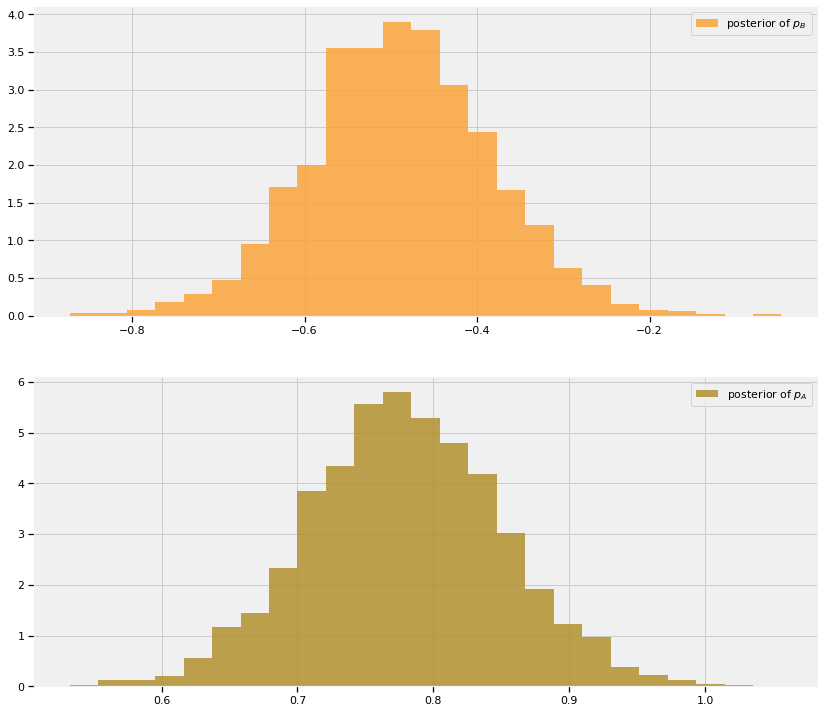

In [70]:
plt.figure(figsize(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(211)

plt.hist(samples[0].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color='#FAA43A', density=True)
plt.legend(loc="upper right")

ax = plt.subplot(212)

plt.hist(samples[1].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color='#B2912F', density=True)
plt.legend(loc="upper right")

In [71]:
alpha_samples_1d_ = samples[0][:, None]  # best to make them 1d
beta_samples_1d_ = samples[1][:, None]

beta_mean = tf.reduce_mean(beta_samples_1d_.numpy().T[0])
alpha_mean = tf.reduce_mean(alpha_samples_1d_.numpy().T[0])


print("beta mean:", beta_mean)
print("alpha mean:", alpha_mean)
def logistic(x, beta, alpha=0):
    """
    Logistic function with alpha and beta.
        
    Args:
      x: independent variable
      beta: beta term 
      alpha: alpha term
    Returns: 
      Logistic function
    """
    return 1.0 / (1.0 + tf.exp((beta * x) + alpha))

t_ = np.linspace(-1, 3, 30)[:, None]
p_t = logistic(t_.T, beta_samples_1d_, alpha_samples_1d_).numpy()
mean_prob_t = logistic(t_.T, beta_mean, alpha_mean)

beta mean: tf.Tensor(0.7788918, shape=(), dtype=float32)
alpha mean: tf.Tensor(-0.4889146, shape=(), dtype=float32)


Text(0.5, 0, 'passenger class')

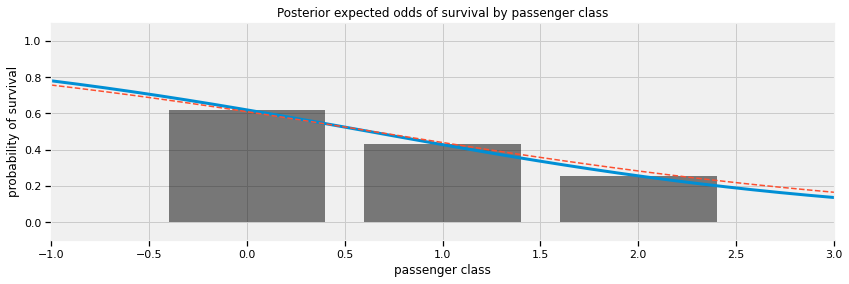

In [72]:
plt.figure(figsize(12.5, 4))

plt.plot(t_, mean_prob_t.numpy().T, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t_, p_t.T[:, 0], ls="--", label="realization from posterior")
plt.bar([0,1,2], pd.DataFrame(titanic_data.numpy()).groupby(0).mean().values.reshape(1,-1)[0], color="k",alpha=0.5)
plt.title("Posterior expected odds of survival by passenger class")
plt.ylim(-0.1, 1.1)
plt.xlim(t_.min(), t_.max())
plt.ylabel("probability of survival")
plt.xlabel("passenger class")

## Generating a distribution from each class

In [73]:
def double_joint_log_prob(obsA, obsB, obsC,
                probA, probB, probC):


    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_prob_B = tfd.Uniform(low=0., high=1.)
    rv_prob_C = tfd.Uniform(low=0, high=1.)

    rv_obs_A = tfd.Bernoulli(probs=probA)
    rv_obs_B = tfd.Bernoulli(probs=probB)
    rv_obs_C = tfd.Bernoulli(probs=probC)

    probability = (rv_prob_A.log_prob(probA)
        + rv_prob_B.log_prob(probB)
        + rv_prob_C.log_prob(probC)
        + tf.reduce_sum(rv_obs_A.log_prob(obsA))
        + tf.reduce_sum(rv_obs_B.log_prob(obsB))
        + tf.reduce_sum(rv_obs_C.log_prob(obsC)))

    return probability

## Setting parameters for MCMC
Chain initial state is where we will start exploring the space.  We'll use the mean of the observations.

In [74]:

number_of_steps = 30000 
burnin = 8000 
leapfrog_steps=5


# Set the chain's start state.
initial_chain_state = [    
    tf.reduce_mean(tf.cast(first,tf.float32)),
    tf.reduce_mean(tf.cast(second,tf.float32)),
    tf.reduce_mean(tf.cast(third,tf.float32))
]


# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: double_joint_log_prob(first, second, third, *args)

In [75]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=leapfrog_steps)

## Sample the Chain
Generate samples from our chain

In [76]:
# Apply a simple step size adaptation during burnin
@tf.function
def run_chain():
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc_kernel,
      num_adaptation_steps=int(.8 * burnin),
      target_accept_prob=np.float64(.65))

  return tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=adaptive_kernel,
    trace_fn=lambda cs, kr: kr)

In [77]:
samples, kernel_results = run_chain()

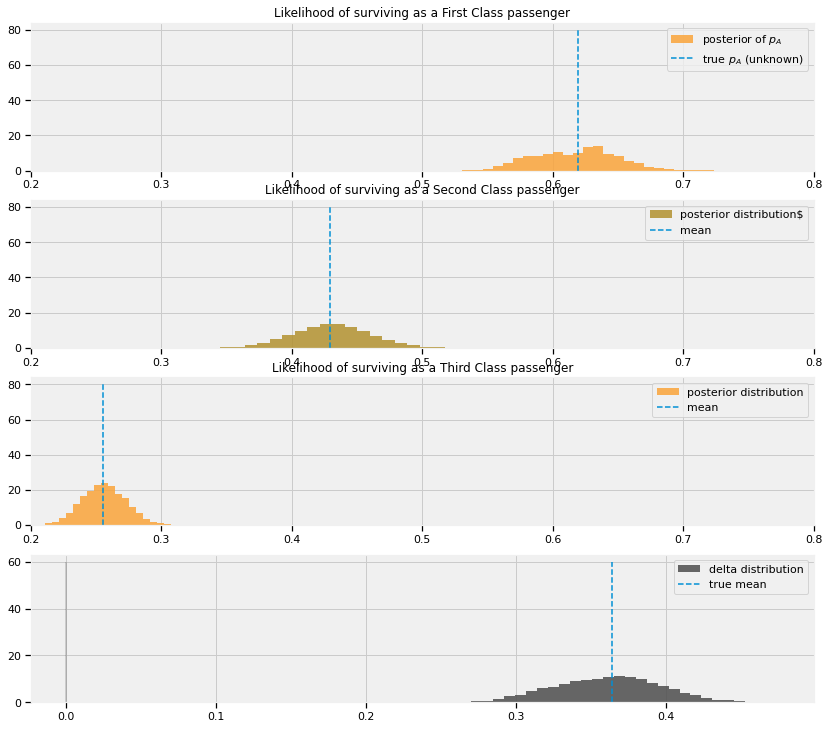

In [78]:
plt.figure(figsize(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(411)

plt.xlim(0.2, .8)
plt.hist(samples[0].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color='#FAA43A', density=True)
plt.vlines(first.mean(), 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Likelihood of surviving as a First Class passenger")

ax = plt.subplot(412)

plt.xlim(0.2, .8)
plt.hist(samples[1].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior distribution$", color='#B2912F', density=True)
plt.vlines(second.mean(), 0, 80, linestyle="--", label="mean")
plt.legend(loc="upper right")
plt.title("Likelihood of surviving as a Second Class passenger")

ax = plt.subplot(413)

plt.xlim(0.2, .8)
plt.hist(samples[2].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior distribution", color='#FAA43A', density=True)
plt.vlines(third.mean(), 0, 80, linestyle="--", label="mean")
plt.legend(loc="upper right")
plt.title("Likelihood of surviving as a Third Class passenger")

ax = plt.subplot(414)
plt.hist((samples[0]-samples[2]).numpy(), histtype='stepfilled', bins=30, alpha=0.85,
         label="delta distribution", color='#4D4D4D', density=True)
plt.vlines(first.mean() - third.mean(), 0, 60, linestyle="--",
           label="true mean")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");